Hi! Much of the computer vision code was generated with ChatGPT in an effot to expedite the more tedious aspects of this project. I will try to outline which parts are GPT vs my own.

Chose: square | Correct
Chose: square | Correct
Chose: square | Correct
Chose: square | Correct
Chose: square | Correct
Chose: square | Incorrect
Chose: circle | Correct
Chose: circle | Correct
Chose: circle | Correct
Chose: circle | Correct
Chose: circle | Correct
Chose: circle | Incorrect
Chose: circle | Incorrect
Chose: circle | Incorrect
Chose: square | Correct
Chose: square | Correct
Chose: square | Correct
Chose: square | Incorrect
Chose: square | Incorrect


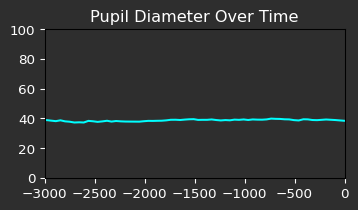

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

import numpy as np
import cv2
import tkinter as tk
import random
from PIL import Image, ImageTk
import math
from collections import deque
import time

class App:
    def __init__(self, window, file_samples=None, file_events=None):

        self.face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
        self.eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')

        self.window = window
        self.window.title("Camera + Game")
        self.window.configure(bg="#2e2e2e")

        # --- Layout Frames ---
        self.left_frame = tk.Frame(window, bg="#2e2e2e")
        self.right_frame = tk.Frame(window, bg="#2e2e2e")

        self.left_frame.pack(side=tk.LEFT)

        self.right_frame.pack(side=tk.RIGHT)

        # --- Camera Setup ---
        self.cap = cv2.VideoCapture(-1) # use camera with most recent id (id for camera can change when unplugged and replugged)
        self.out = cv2.VideoWriter('output.avi', cv2.VideoWriter_fourcc(*'XVID'), 20.0, (640, 480))

        self.video_label = tk.Label(self.left_frame)
        self.video_label.pack()

        # --- Game Canvas ---
        self.canvas_width = 400
        self.canvas_height = 400
        self.canvas = tk.Canvas(self.right_frame, width=self.canvas_width, height=self.canvas_height, bg="black")
        self.canvas.pack()

        self.left_shape = None
        self.right_shape = None
        self.correct_shape = random.choice(['circle', 'square'])
        self.correct_streak = 0
        self.spawn_shapes()

        # --- Score ---
        self.score = 0
        self.score_label = tk.Label(self.right_frame, text=f"Score: {self.score}", font=("Helvetica", 16), fg="white", bg="black")
        self.score_label.pack(pady=10)

        self.feedback_label = tk.Label(self.canvas, text="", font=("Helvetica", 24), fg="white", bg="black")
        self.feedback_label.place(relx=0.5, rely=0.5, anchor="center")

        # -- pupil diameter recording
        self.t0 = time.time() # timestamp at which recording begins (treated as t = 0)
        self.pupil_diameters = []
        self.pupil_times = []
        self.max_data_points = 100  # Limit to last 100 values for smoother graph
        self.eye_candidates_recent_max = 100 # at 10 ms per sample in the worst case, this should give max prob over 1 second
        self.recent_eye_candidates = deque(maxlen=self.eye_candidates_recent_max) # stores most recent 100 eye prediction candidates
        self.most_recent_successful = None # stores the most recent "successful" eye prediction, meaning the most recent with p > 0.5

        # Setup Matplotlib Figure
        self.fig, self.ax = plt.subplots(figsize=(4, 2))
        self.line, = self.ax.plot([], [], color='cyan')
        self.line_smoothed, = self.ax.plot([],[], color='green')
        self.ax.set_ylim(0, 100)
        self.ax.set_title("Pupil Diameter Over Time", color='white')
        self.ax.set_facecolor("#2e2e2e")
        self.fig.patch.set_facecolor('#2e2e2e')
        self.ax.tick_params(axis='x', colors='white')
        self.ax.tick_params(axis='y', colors='white')
        self.ax.title.set_color('white')

        self.canvas_plot = FigureCanvasTkAgg(self.fig, master=self.right_frame)
        self.canvas_plot.get_tk_widget().pack(pady=10)

        # --- Key Bindings ---
        self.window.bind("<KeyPress-Left>", self.choose_left)
        self.window.bind("<KeyPress-Right>", self.choose_right)

        # --- Quit Button ---
        self.quit_button = tk.Button(self.right_frame, text="Quit", command=self.quit)
        self.quit_button.pack(pady=10)

        # --- Output Files
        self.file_samples = file_samples
        self.file_events = file_events

        # finally, start camera updates, which gets everything going
        self.update_camera() 

    def draw_shape(self, shape_type, x_center):
        y_center = 150
        size = 50
        if shape_type == 'circle':
            self.canvas.create_oval(x_center - size, y_center - size,
                                    x_center + size, y_center + size,
                                    fill='blue')
        elif shape_type == 'square':
            self.canvas.create_rectangle(x_center - size, y_center - size,
                                        x_center + size, y_center + size,
                                        fill='green')

    def spawn_shapes(self):
        self.canvas.delete("all")
        shapes = ['circle', 'square']
        random.shuffle(shapes)

        # Place the current correct shape on a random side
        if self.correct_shape == shapes[0]:
            self.correct_side = 'left'
        else:
            self.correct_side = 'right'

        self.current_left_shape = shapes[0]
        self.current_right_shape = shapes[1]

        self.draw_shape(self.current_left_shape, 100)
        self.draw_shape(self.current_right_shape, 300)

    def choose_left(self, event):
        choice = self.current_left_shape
        correct = self.correct_side == 'left'
        self.handle_choice(choice, correct)

    def choose_right(self, event):
        choice = self.current_right_shape
        correct = self.correct_side == 'right'
        self.handle_choice(choice, correct)

    def handle_choice(self, shape_type, correct):
        self.record_choice(shape_type, correct)

        if correct:
            self.correct_streak += 1
            switch_prob = min(0.1 * self.correct_streak, 0.9)  # cap at 90% chance to switch
            if random.random() < switch_prob:
                self.correct_shape = 'circle' if self.correct_shape == 'square' else 'square'
                self.correct_streak = 0
        else:
            self.correct_streak = 0  # reset on wrong choice

        self.feedback_label.config(text="✅ Correct!" if correct else "❌ Incorrect", fg="green" if correct else "red")
        self.window.after(1000, self.clear_feedback_and_next)

    def clear_feedback_and_next(self):
        self.feedback_label.config(text="")
        self.spawn_shapes()

    def record_choice(self, shape_type, correct):
        print(f"Chose: {shape_type} | {'Correct' if correct else 'Incorrect'}")
        self.file_events.write(f"{self.score},{time.time() - self.t0},{shape_type},{'Correct' if correct else 'Incorrect'},,,\n")
        self.score += 1
        self.score_label.config(text=f"Score: {self.score}")

    def quit(self):
        self.cap.release()
        self.out.release()
        self.window.destroy()


    ### MAIN LOOP

    def update_camera(self):
        ret, frame = self.cap.read()
        if ret:
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            gray = cv2.equalizeHist(gray)

            # Detect eyes directly from the full frame
            eyes = self.eye_cascade.detectMultiScale(
                gray,
                scaleFactor=1.1,
                minNeighbors=5,
                minSize=(30, 30)
            )

            # TODO maybe only show the "most likely" eye?
            if len(eyes) > 0:

                ### Heuristic processing to determine which eye to show
                eye_candidates_cur = np.empty(shape=(len(eyes), 4))
                for i, pos in enumerate(eyes):
                    self.recent_eye_candidates.appendleft(np.array(pos)) # deque's maxlen means that when items are added such that the maxlen is exceeded,
                    # older items will be booted off
                    eye_candidates_cur[i] = pos

                recent_candidates_np = np.empty(shape=(len(self.recent_eye_candidates), 4))
                for i, pos in enumerate(self.recent_eye_candidates):
                    recent_candidates_np[i] = pos
                # display(recent_candidates_np)
                
                dist_from = np.empty(shape=(len(self.recent_eye_candidates), len(eyes)))

                # display(eye_candidates_cur, recent_candidates_np)
                for i, pos in enumerate(eye_candidates_cur):
                    dist = np.linalg.norm(pos - recent_candidates_np, ord=2, axis=1) # ord=2 for L2 norm, euclidean distance
                    # print(f'shape of norm {dist.shape}')
                    dist_from[:,i] = dist
                # display(f'recent candidates', recent_candidates_np, f'distance from those candidates', dist_from)

                dist_smallest = np.argmin(dist_from, axis=1)
                # display(f'dist_smallest:', dist_smallest)

                prob_show = np.empty(shape=len(eye_candidates_cur))
                for i in range(len(eye_candidates_cur)):
                    prob_show[i] = np.sum(dist_smallest == i)
                prob_show /= self.eye_candidates_recent_max

                # display(f'prob_show', prob_show)

                eye_show_idx = np.argmin(prob_show)

                prob_highest = prob_show[eye_show_idx]

                dist_highest_to_most_recent = 0
                if not self.most_recent_successful is None:
                    dist_highest_to_most_recent = np.linalg.norm(eyes[eye_show_idx] - self.most_recent_successful, ord=2) / self.eye_candidates_recent_max
                    dist_highest_to_most_recent = int(dist_highest_to_most_recent)

                # if the current best is pretty far from the most recent successful eye, then it may be that cv2 momentarily dropped
                # the good eye prediction and only has a false positive to work with. During this time, we should just show the most recent successful
                if prob_highest < 0.5 and not self.most_recent_successful is None:
                    eyes = [self.most_recent_successful]
                    eye_show_idx = 0
                else:
                    (ex, ey, ew, eh) = eyes[eye_show_idx]
                    # self.most_recent_successful = (ex, ey, ex+ew, ey+eh)
                    self.most_recent_successful = eyes[eye_show_idx]

                for i, (ex, ey, ew, eh) in enumerate(eyes):
                    if not i == eye_show_idx:
                        continue
                    # pt1, pt2 = (ex, ey), (ex+ew, ey+eh)
                    # cv2.rectangle(frame, pt1=pt1, pt2=pt2, color=(0,255,255), thickness=2)

                    eye_roi = gray[ey:ey+eh, ex:ex+ew]
                    eye_roi = cv2.GaussianBlur(eye_roi, (7, 7), 0)
                    _, threshold = cv2.threshold(eye_roi, 30, 255, cv2.THRESH_BINARY_INV)
                    contours, _ = cv2.findContours(threshold, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

                    ## ALSO LOOK FOR PUPIL USING DARKEST PIXEL

                        # fallback to darkest pixel
                    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(eye_roi)
                    center = (ex + min_loc[0], ey + min_loc[1])
                    cv2.circle(frame, center, 5, (255, 0, 0), 2)

                    # try to find eye by looking at area nearest darkest spot
                    range_look_x, range_look_y = 50, (25, 50) # number of pixels
                    dx, dy = min_loc
                    xl, xr = ex + dx - range_look_x, ex + dx + range_look_x
                    yl, yr = ey + dy - range_look_y[0], ey + dy + range_look_y[1]
                    eye_roi = gray[yl:yr, xl:xr]

                    if eye_roi.size == 0:
                        continue

                    pt1, pt2 = (xl,yl), (xr, yr)
                    cv2.rectangle(frame, pt1=pt1, pt2=pt2, color=(0,0, prob_show[i] * 255), thickness=2)
                    cv2.putText(img=frame, text=f'{dist_highest_to_most_recent}', org=pt2, fontFace=cv2.FONT_HERSHEY_COMPLEX, fontScale=0.7, color=(0,0,255))

                    eye_roi = cv2.GaussianBlur(eye_roi, (7, 7), 0)
                    thresh = 10 # good threshold that makes it so that even the slight difference between pupil and iris is noted
                    _, threshold = cv2.threshold(eye_roi, thresh=thresh, maxval=255, type=cv2.THRESH_BINARY_INV)

                    ### DEBUG
                    ### Grayscale and markers
                    try:
                        frame[yl:yr, xl:xr] = cv2.cvtColor(src=threshold, code=cv2.COLOR_GRAY2BGR)    
                        # frame[yl:yr, xl:xr] = cv2.cvtColor(src=eye_roi, code=cv2.COLOR_GRAY2BGR)    
                    except:
                        # display(frame.shape, gray.shape, eye_roi.shape)
                        pass

                    # after grayscale is overlaid, show the circle for the darkest part
                    cv2.circle(frame, center, 5, (255, 0, 0), 2)
                    ### Grayscale and markers

                    contours, _ = cv2.findContours(threshold, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

                    if contours:
                        largest = max(contours, key=cv2.contourArea)
                        (cx, cy), radius = cv2.minEnclosingCircle(largest)
                        diameter = 2 * radius
                        time_rel = time.time() - self.t0
                        self.pupil_diameters.append(diameter)
                        self.pupil_times.append(time_rel)
                        self.file_samples.write(f'{time_rel},{diameter}\n')

                        if len(self.pupil_diameters) > self.max_data_points:
                            self.pupil_diameters.pop(0) # aware that this is slow
                            self.pupil_times.pop(0)

                        center = (int(xl + cx), int(yl + cy))
                        cv2.circle(frame, center, int(radius), (0, 255, 0), 2)

            self.out.write(frame)
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            img = Image.fromarray(frame)
            imgtk = ImageTk.PhotoImage(image=img)
            self.video_label.imgtk = imgtk
            self.video_label.configure(image=imgtk)

            # Update plot
            # if len(self.pupil_diameters) > 0:
            #     pupil_diameters_smoothed = np.convolve(a=self.pupil_diameters, v=np.full(shape=20, fill_value=1/20))
            #     self.line_smoothed.set_data(range(len(pupil_diameters_smoothed)), pupil_diameters_smoothed)

            plot_duration = 3000 # number of miliseconds to plot into the past

            # display pupil diameter in the last few seconds
            if len(self.pupil_diameters) > 0:
                times = np.array(self.pupil_times) * 1000
                times -= times[-1] # set most recent time stamp at t=0,
                # all other times are in the past relative to it

                self.line.set_data(times, self.pupil_diameters)
                # self.ax.set_xlim(0, len(self.pupil_diameters) if len(self.pupil_diameters) > 10 else 10)

                self.ax.set_xlim(left=-plot_duration, right=0)
                self.canvas_plot.draw()

        self.window.after(10, self.update_camera)

# Run it!
cn_TIMESTAMP = 'Timestamp'
cn_PUPIL_DIAM = 'Pupil Diameter'
cn_TRIAL_IDX = 'Trial Index'

# time columns
cn_TIME_BEG = 'Time Beg' # time at which trial begins
cn_TIME_BEHAVIOR = 'Time Behavior' # time at which behavior/action is taken
cn_TIME_REWARD = 'Time Reward' # time at which reward is shown/given/administered
cn_TIME_END = 'Time End' # time at which trial ends
# having all of these timestamps allows us to retrieve pupil samples for each trial individually

root = tk.Tk()
file_time = time.strftime('%Y-%m-%d %H:%M:%S') # https://stackoverflow.com/a/14229023/13367562
filename_samples = f'recording_{file_time}_samples.csv'
filename_events = f'recording_{file_time}_events.csv'
with open(filename_samples, 'w') as f_samples, open(filename_events, 'w') as f_events:
    file_and_columns = [
        (f_samples, [cn_TIMESTAMP, cn_PUPIL_DIAM]), 
        (f_events, [cn_TRIAL_IDX, cn_TIME_BEG, cn_TIME_BEHAVIOR, cn_TIME_REWARD, cn_TIME_END]),
        ]
    
    for f, c in file_and_columns:
        cols_str = ','.join(c)
        f.write(f'{cols_str}\n')

    app = App(root, file_samples=f_samples, file_events=f_events)
    root.mainloop()
